# `Beer Mart Recommendation System`

##### The purpose of this assignment is to build a Collaborative Recommendation System (both Used based & Item based) for a store called "BeerMart", where customers will be recommended the beer that they are most likely to buy.

## Step 1: Importing import packages and Reading Data

In [321]:
# import libraries
import pandas as pd
import numpy as np

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [334]:
# Reading ratings file
beer_ratings = pd.read_csv('beer_data.csv')
beer_ratings.head()

,beer_beerid,review_profilename,review_overall
0,48215,stcules,3.0
1,52159,oline73,3.0
2,52159,alpinebryant,3.0
3,52159,rawthar,4.0
4,52159,RangerClegg,3.5


## Step 2: Inspecting the Dataframe

In [335]:
beer_ratings.dtypes

beer_beerid             int64
review_profilename     object
review_overall        float64
dtype: object

In [336]:
beer_ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
beer_beerid,475984.0,21660.550611,21793.437326,3.0,1716.0,13892.0,39397.0,77317.0
review_overall,475984.0,3.814827,0.720411,0.0,3.5,4.0,4.5,5.0


In [337]:
shape = beer_ratings.shape
shape

(475984, 3)

## Step 3: Data Cleansing

### Handling Duplicate Rows

In [338]:
# Removing duplicates having both beer & user duplicated, 
# this will ensure that no 2 reviews from single user to same beer are counted & cumulated.
beer_ratings.drop_duplicates(subset=['beer_beerid','review_profilename'], inplace = True)
print(shape[0] - beer_ratings.shape[0])
print(beer_ratings.shape)

1424
(474560, 3)


*There are 1424 duplicate entries for any beer.*

### Handling Null Values

In [339]:
# Checking for total count and percentage of null values in all columns of the dataframe.

total = pd.DataFrame(beer_ratings.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(beer_ratings.isnull().sum()/beer_ratings.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])
pd.concat([total, percentage], axis = 1)

,Total,Percentage
review_profilename,98,0.02
review_overall,0,0.00
beer_beerid,0,0.00


### Removing rows where a particular column has high missing values

In [340]:
beer_ratings['review_profilename'].isnull().sum()

98

In [341]:
# removing rows where a particular column has high missing values because the column cannot be removed because of its importance
beer_ratings = beer_ratings[~pd.isnull(beer_ratings['review_profilename'])]
beer_ratings.shape

(474462, 3)

## Step 4: Data Preparation
###### Choose only those beers that have at least N number of reviews.
*Figure out an appropriate value of N using EDA; this may not have one correct answer, but you should not choose beers that have an extremely low number of ratings.*

### Finding all distinct beers & total reviews they received

In [342]:
reviewsperbeer=beer_ratings.groupby('beer_beerid')['review_overall'].count().reset_index().sort_values(by=['review_overall'],ascending=False)
reviewsperbeer.head()

,beer_beerid,review_overall
1574,2093,977
338,412,966
1427,1904,902
818,1093,840
78,92,812


In [332]:
round(reviewsperbeer.describe(),2).T

,count,mean,std,min,25%,50%,75%,max
beer_beerid,40304.0,36973.17,22544.76,3.0,16879.75,37366.5,56233.5,77317.0
review_overall,40304.0,11.77,41.89,1.0,1.00,2.0,5.0,977.0


### Visually representing the frequency of total reviews received by different beers

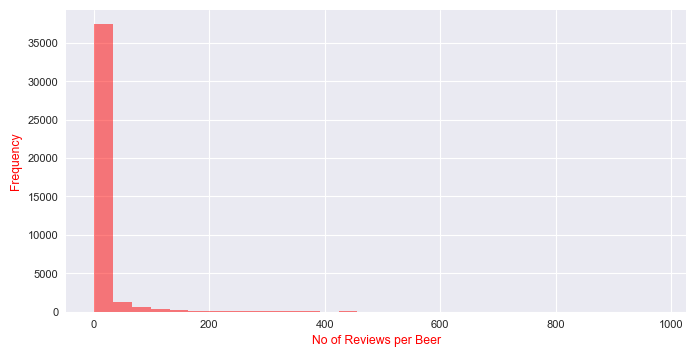

In [343]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(8, 4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("darkgrid") # white/whitegrid/dark/darkgrid/ticks
sns.set_context("paper") # talk/poster

plt.hist(reviewsperbeer['review_overall'],alpha=0.5,color='red', bins=30)
# plot x axis label
plt.xlabel('No of Reviews per Beer', color='r')
# plot y axis label
plt.ylabel('Frequency', color='r')
# display the plot
plt.show()

### Finding Count & Percentage of Beers with just 1 review

In [214]:
print(reviewsperbeer.loc[reviewsperbeer['review_overall']==1].shape[0])
print(round(100*(reviewsperbeer.loc[reviewsperbeer['review_overall']==1].shape[0]/reviewsperbeer.shape[0]),2))

18080
44.86


In [344]:
reviewsfrequency=reviewsperbeer.groupby('review_overall')['beer_beerid'].count().reset_index()
reviewsfrequency.columns.values[:]=['Total Beer Reviews','Review Frequency']
reviewsfrequency.head(10)

,Total Beer Reviews,Review Frequency
0,1,18080
1,2,6183
2,3,3079
3,4,1895
4,5,1350
5,6,959
6,7,785
7,8,556
8,9,478
9,10,401


##### From the above Analysis, we get the following highlighted points
 - There are 40308 distinct beers in total
 - Beers have reviews count in range of 1 to 977, beer - 2093 have highest number of reviews(977).
 - 18080 or 44.86% beers have only 1 review.
 - It seems that most beers get very few reviews. In fact very few beers have large enough number of reviews required for building recommendation system based on collaborative filtering.
 
##### To find an ideal value of N its important that we choose beers having large enough number of reviews to avoid cold start problem. 

### Filtering beers having atleast 50 reviews

In [346]:
above50reviewsperbeer = reviewsperbeer.loc[reviewsperbeer['review_overall'] >= 50]
above50reviewsperbeer.columns.values[1]='Total Review Count of Beer'
above50reviewsperbeer.head()

,beer_beerid,Total Review Count of Beer
1574,2093,977
338,412,966
1427,1904,902
818,1093,840
78,92,812


### Again inspectingting the frequency of total reviews received by different beers

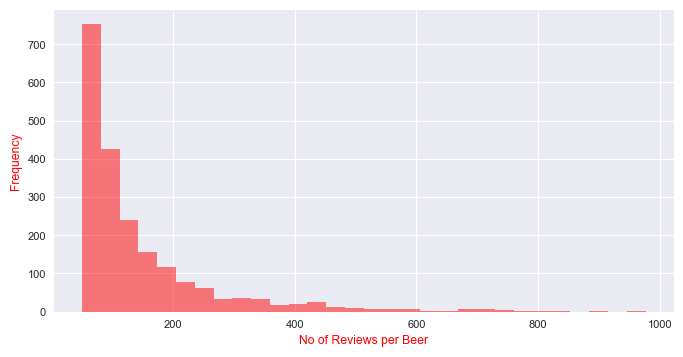

In [348]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(8, 4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("darkgrid") # white/whitegrid/dark/darkgrid/ticks
sns.set_context("paper") # talk/poster

plt.hist(above50reviewsperbeer['review_overall'],alpha=0.5,color='red', bins=30)
# plot x axis label
plt.xlabel('No of Reviews per Beer', color='r')
# plot y axis label
plt.ylabel('Frequency', color='r')
# display the plot
plt.show()

### Finding all distinct reviewers & total beers they reveiwed

In [349]:
reviewsperreviewer=beer_ratings.groupby('review_profilename')['review_overall'].count().reset_index().sort_values(by=['review_overall'],ascending=False)
reviewsperreviewer.head()

,review_profilename,review_overall
18188,northyorksammy,1842
17373,mikesgroove,1373
1629,BuckeyeNation,1336
8470,Thorpe429,1072
1910,ChainGangGuy,1046


In [352]:
round(reviewsperreviewer.describe(),2).T

,count,mean,std,min,25%,50%,75%,max
Total Reviews by User,22497.0,21.09,65.39,1.0,1.0,3.0,11.0,1842.0


 - There are 22497 distinct beers in total
 - northyorksammy have reviewed the highest no of beers(1842).

### Filtering beer database based on users who have reviewed atleast 30 beers each

In [353]:
above30reviewsperreviewer = reviewsperreviewer.loc[reviewsperreviewer['review_overall'] >= 30]
above30reviewsperreviewer.columns.values[1]='Total Reviews by User'
above30reviewsperreviewer.head()

,review_profilename,Total Reviews by User
18188,northyorksammy,1842
17373,mikesgroove,1373
1629,BuckeyeNation,1336
8470,Thorpe429,1072
1910,ChainGangGuy,1046


### Again inspectingting the frequency of total reviews reviewed by various reviewers

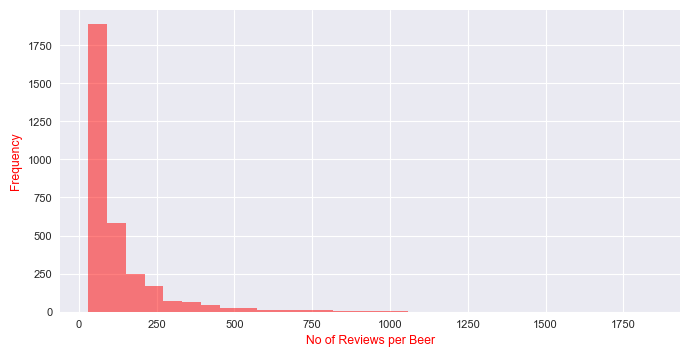

In [354]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(8, 4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("darkgrid") # white/whitegrid/dark/darkgrid/ticks
sns.set_context("paper") # talk/poster

plt.hist(above30reviewsperreviewer['review_overall'],alpha=0.5,color='red', bins=30)
# plot x axis label
plt.xlabel('No of Reviews per Beer', color='r')
# plot y axis label
plt.ylabel('Frequency', color='r')
# display the plot
plt.show()

### Filtering original data by these chosen beer and user ids

In [355]:
beers_for_recommendation = pd.merge(beer_ratings, above50reviewsperbeer, how='inner', on='beer_beerid')
beers_for_recommendation = pd.merge(beers_for_recommendation, above30reviewsperreviewer, how='inner', on='review_profilename')
beers_for_recommendation.shape

(230088, 5)

In [356]:
beers_for_recommendation.head()

,beer_beerid,review_profilename,review_overall,Total Review Count of Beer,Total Reviews by User
0,436,Brent,3.0,127,518
1,10784,Brent,4.0,119,518
2,16074,Brent,4.0,431,518
3,33644,Brent,4.0,261,518
4,1122,Brent,5.0,54,518


In [357]:
beers_for_recommendation.describe().T

,count,mean,std,min,25%,50%,75%,max
beer_beerid,230088.0,15773.718295,18910.919154,5.0,1089.0,4161.0,29619.0,75086.0
review_overall,230088.0,3.869528,0.678448,1.0,3.5,4.0,4.5,5.0
Total Review Count of Beer,230088.0,233.838583,185.349133,50.0,97.0,171.0,314.0,977.0
Total Reviews by User,230088.0,233.050581,229.966623,30.0,78.0,155.0,299.0,1842.0


In [358]:
beers_for_recommendation['review_profilename'].value_counts().head()

BuckeyeNation     518
mikesgroove       505
BEERchitect       460
northyorksammy    455
WesWes            455
Name: review_profilename, dtype: int64

##### This beer subset have substantial ratings by both users & beers.

## Step 4: Data Exploration

In [359]:
beers_for_recommendation.head()

,beer_beerid,review_profilename,review_overall,Total Review Count of Beer,Total Reviews by User
0,436,Brent,3.0,127,518
1,10784,Brent,4.0,119,518
2,16074,Brent,4.0,431,518
3,33644,Brent,4.0,261,518
4,1122,Brent,5.0,54,518


### What are the unique values of ratings?

In [360]:
sorted(beers_for_recommendation['review_overall'].unique())

[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

### Percentage Occurence of the Different Values of Ratings

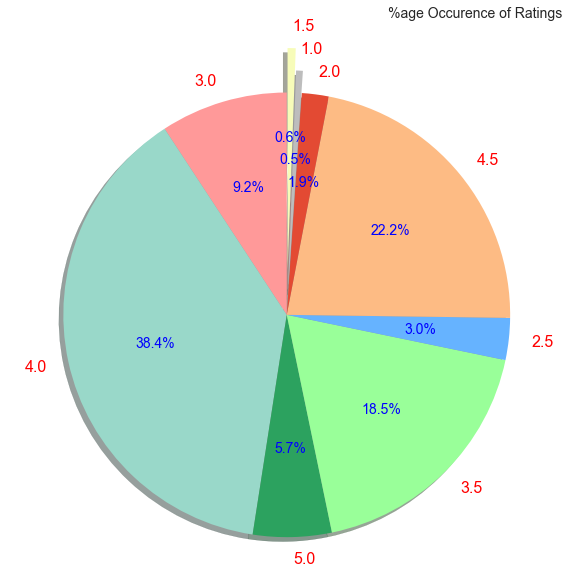

In [362]:
from collections import Counter

labels, values = zip(*Counter(beers_for_recommendation["review_overall"]).items())
colors = ["#ff9999", "#99d8c9", "#2ca25f", "#99ff99","#66b3ff","#fdbb84","#e34a33","#bdbdbd","#f7fcb9","#99ff99","#f7fcb9","#fec44f","#d95f0e","#dd1c77","#99ff99"]
explode = (0, 0, 0, 0, 0, 0, 0, 0.1, 0.2)
piechart_df = (pd.DataFrame(list(values),list(labels)))
piechart_df = piechart_df.reset_index()

fig = plt.figure(figsize=[8,8])
patches, texts, autotexts = plt.pie(piechart_df[0], labels=piechart_df["index"], \
                                    startangle=90, colors = colors, autopct='%.1f%%', \
                                    shadow=True,explode=explode, textprops={'fontsize': 10})

plt.title("%age Occurence of Ratings", fontsize=14, loc='right')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
for autotext in autotexts:
    autotext.set_color('blue')
    autotext.set_fontsize('14')

for text in texts:
    text.set_color('red')
    text.set_fontsize('16')    
    
    
plt.tight_layout()    
plt.show()

### Visualise the Average Beer Ratings:

In [363]:
beer_mean_rating = pd.DataFrame(beers_for_recommendation.groupby('beer_beerid')['review_overall'].mean())
beer_mean_rating.head()

,review_overall
beer_beerid,
5,3.532609
6,3.707895
7,3.272109
10,3.859116
14,3.911765


In [364]:
pd.DataFrame(beer_mean_rating['review_overall']).describe().T

,count,mean,std,min,25%,50%,75%,max
review_overall,2064.0,3.805672,0.364112,1.258333,3.65592,3.869565,4.042882,4.636364


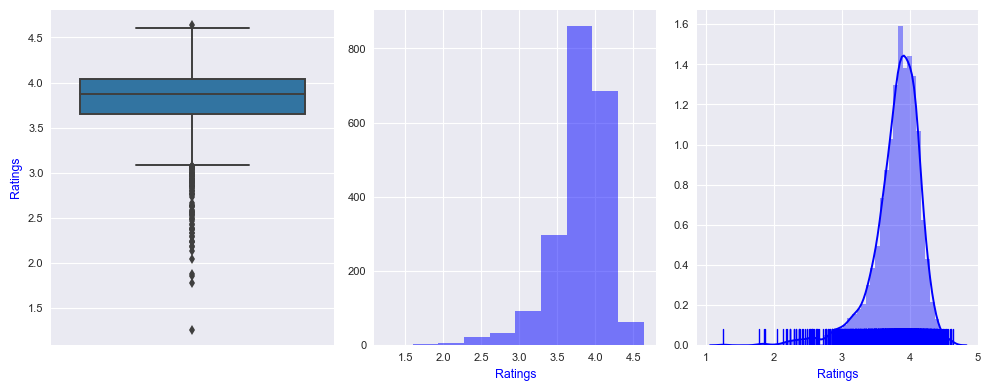

In [365]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(10,4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("darkgrid") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

# subplot 1
plt.subplot(1, 3, 1)
sns.boxplot(y=beer_mean_rating['review_overall'])
plt.ylabel('Ratings', color='b')

# subplot 3
plt.subplot(1, 3, 2)
plt.hist(beer_mean_rating['review_overall'],alpha=0.5,color='blue')
plt.xlabel('Ratings', color='b')

# subplot 3
plt.subplot(1, 3, 3)
sns.distplot(beer_mean_rating['review_overall'], color='blue', rug=True)
plt.xlabel('Ratings', color='b')

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

##### The mean and median of average beer ratings are respectively `3.805672` & `3.869565`. Hence it almost follows a normal distribution.

### Visualise the Average User Ratings:

In [366]:
user_mean_rating = pd.DataFrame(beers_for_recommendation.groupby('review_profilename')['review_overall'].mean())
user_mean_rating.head()

,review_overall
review_profilename,
0110x011,4.333333
05Harley,4.116667
100floods,4.155172
1759Girl,3.725000
1fastz28,3.875000


In [367]:
pd.DataFrame(user_mean_rating['review_overall']).describe().T

,count,mean,std,min,25%,50%,75%,max
review_overall,3176.0,3.875033,0.219189,2.833333,3.75,3.901286,4.022727,4.456522


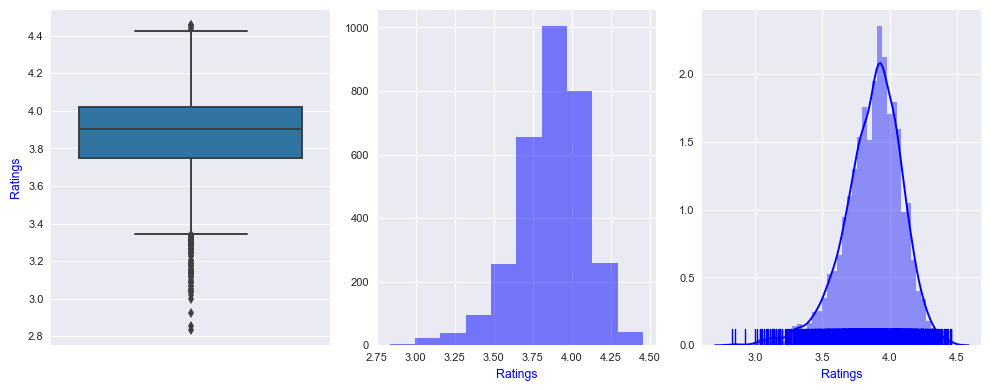

In [368]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(10,4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("darkgrid") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

# subplot 1
plt.subplot(1, 3, 1)
sns.boxplot(y=user_mean_rating['review_overall'])
plt.ylabel('Ratings', color='b')

# subplot 3
plt.subplot(1, 3, 2)
plt.hist(user_mean_rating['review_overall'],alpha=0.5,color='blue')
plt.xlabel('Ratings', color='b')

# subplot 3
plt.subplot(1, 3, 3)
sns.distplot(user_mean_rating['review_overall'], color='blue', rug=True)
plt.xlabel('Ratings', color='b')

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

##### The mean and median of average beer ratings are respectively `3.875033` & `3.901286`. Hence it almost follows a normal distribution.

### Visualise the Average Number of Ratings given to Beers:

In [370]:
mean_beer_review_count = pd.DataFrame(beers_for_recommendation.groupby('beer_beerid')['review_overall'].count())
mean_beer_review_count.head()

,review_overall
beer_beerid,
5,92
6,190
7,147
10,181
14,51


In [371]:
pd.DataFrame(mean_beer_review_count['review_overall']).describe().T

,count,mean,std,min,25%,50%,75%,max
review_overall,2064.0,111.476744,83.272159,26.0,57.0,82.0,133.0,600.0


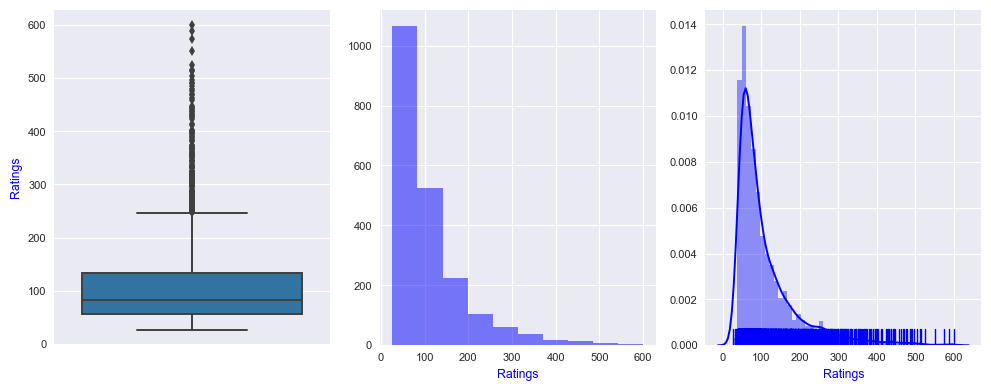

In [372]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(10,4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("darkgrid") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

# subplot 1
plt.subplot(1, 3, 1)
sns.boxplot(y=mean_beer_review_count['review_overall'])
plt.ylabel('Ratings', color='b')

# subplot 3
plt.subplot(1, 3, 2)
plt.hist(mean_beer_review_count['review_overall'],alpha=0.5,color='blue')
plt.xlabel('Ratings', color='b')

# subplot 3
plt.subplot(1, 3, 3)
sns.distplot(mean_beer_review_count['review_overall'], color='blue', rug=True)
plt.xlabel('Ratings', color='b')

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

##### The mean and median of beer review count are respectively `111.5` & `82.0`. Hence it almost follows a normal distribution but is left skewed.

### Visualise the Average Number of Ratings given by the Users:

In [378]:
mean_user_review_count = pd.DataFrame(beers_for_recommendation.groupby('review_profilename')['review_overall'].count())
mean_user_review_count.head()

,review_overall
review_profilename,
0110x011,30
05Harley,30
100floods,29
1759Girl,40
1fastz28,96


In [379]:
pd.DataFrame(mean_user_review_count['review_overall']).describe().T

,count,mean,std,min,25%,50%,75%,max
review_overall,3176.0,72.445844,64.243583,2.0,31.0,49.0,89.0,518.0


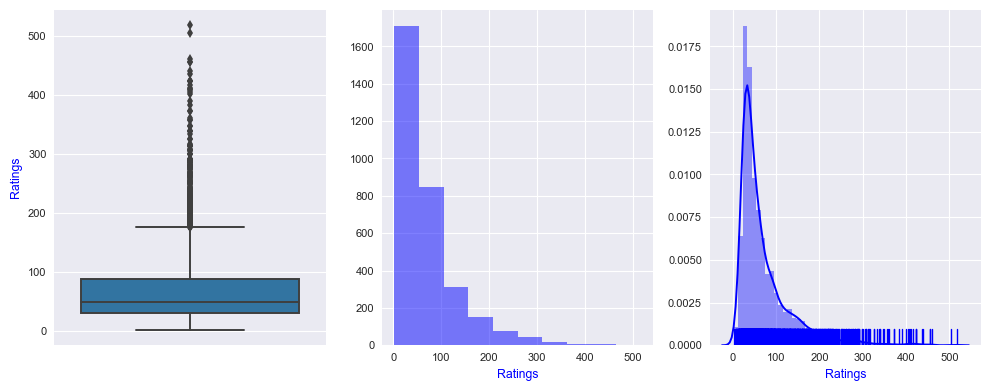

In [380]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(10,4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("darkgrid") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

# subplot 1
plt.subplot(1, 3, 1)
sns.boxplot(y=mean_user_review_count['review_overall'])
plt.ylabel('Ratings', color='b')

# subplot 3
plt.subplot(1, 3, 2)
plt.hist(mean_user_review_count['review_overall'],alpha=0.5,color='blue')
plt.xlabel('Ratings', color='b')

# subplot 3
plt.subplot(1, 3, 3)
sns.distplot(mean_user_review_count['review_overall'], color='blue', rug=True)
plt.xlabel('Ratings', color='b')

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

##### The mean and median of user review count are respectively `72.4` & `49.0`. Hence it almost follows a normal distribution but is left skewed.

## Step 5: Recommendation Models

### Dividing the dataset into train and test

In [381]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(beers_for_recommendation, test_size=0.30, random_state=31)

In [382]:
print(train.shape)
print(test.shape)

(161061, 5)
(69027, 5)


In [383]:
train.head()

,beer_beerid,review_profilename,review_overall,Total Review Count of Beer,Total Reviews by User
57389,92,zhanson88,4.0,812,111
123535,34315,dyan,4.5,95,459
158813,31731,FickleBeast,3.0,82,96
148974,42533,Gmann,4.0,343,406
226161,47731,jcartamdg,4.0,132,38


### User Based Similarity

In [384]:
# pivot ratings into beer features
df_beer_features = train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(0)

In [385]:
df_beer_features.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,...,72138,73131,74123,74272,74323,74390,74548,74579,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100floods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1759Girl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1fastz28,0.0,3.5,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [386]:
df_beer_features.shape

(3176, 2064)

##### The training data set has 3176 reviewers and 2064 beers.

### Copy train and test dataset
These dataset will be used for prediction and evaluation. 
- Dummy train will be used later for prediction of the beers which has not been rated by the user. To ignore the beers rated by the user, we will mark it as 0 during prediction. The beers not rated by user is marked as 1 for prediction. 
- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the beers rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [387]:
dummy_train = train.copy()
dummy_test = test.copy()

In [388]:
dummy_train['review_overall'] = dummy_train['review_overall'].apply(lambda x: 0 if x>=1 else 1)
dummy_test['review_overall'] = dummy_test['review_overall'].apply(lambda x: 1 if x>=1 else 0)

In [390]:
print(dummy_train.shape)
print(dummy_test.shape)

(161061, 5)
(69027, 5)


In [391]:
# The movies not rated by user is marked as 1 for prediction. 
dummy_train = dummy_train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(1)

# The movies not rated by user is marked as 0 for evaluation. 
dummy_test = dummy_test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(0)

In [392]:
dummy_train.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,...,72138,73131,74123,74272,74323,74390,74548,74579,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
05Harley,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
100floods,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1759Girl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1fastz28,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [393]:
dummy_test.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,...,72138,73131,74123,74272,74323,74390,74548,74579,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100floods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1759Girl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1fastz28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### User Similarity Matrix (Using Cosine Similarity)

In [394]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
reviewer_correlation = 1 - pairwise_distances(df_beer_features, metric='cosine')
reviewer_correlation[np.isnan(reviewer_correlation)] = 0
print(reviewer_correlation)

[[1.         0.         0.0602183  ... 0.         0.         0.        ]
 [0.         1.         0.10346685 ... 0.03699533 0.0236273  0.        ]
 [0.0602183  0.10346685 1.         ... 0.0406859  0.04209458 0.        ]
 ...
 [0.         0.03699533 0.0406859  ... 1.         0.         0.        ]
 [0.         0.0236273  0.04209458 ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [395]:
reviewer_correlation.shape

(3176, 3176)

##### The training data set has 3176 reviewers and 2064 beers. The correlation matrix for user-based similarity will be of the shape 3176 x 3176. This matrix indicates to what extent the users are related to other users.

### Using adjusted Cosine 

#### Adjusted cosine similarity is used for user-user similarity, as different users can have different behaviour. A user will rate in the range of 1-3 star for the worst to best beer, whereas a different user will rate in the range of 1-5 star for the same set of beers. To bring both the users on par, the ratings are normalised using adjusted cosine similarity.

### Here, not removing the NaN values and calculating the mean only for the beers rated by the user

In [396]:
beer_features_user = train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [397]:
beer_features_user.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,...,72138,73131,74123,74272,74323,74390,74548,74579,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05Harley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100floods,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1759Girl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1fastz28,NaN,3.5,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalising the rating of the movie for each user around 0 mean

In [398]:
mean = np.nanmean(beer_features_user, axis=1)
df_subtracted_user = (beer_features_user.T-mean).T

In [399]:
df_subtracted_user.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,...,72138,73131,74123,74272,74323,74390,74548,74579,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05Harley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100floods,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1759Girl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1fastz28,NaN,-0.414286,NaN,0.085714,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.414286,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finding cosine similarity

In [400]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
reviewer_correlation = 1 - pairwise_distances(df_subtracted_user.fillna(0), metric='cosine')
reviewer_correlation[np.isnan(reviewer_correlation)] = 0
print(reviewer_correlation)

[[ 1.          0.         -0.06414558 ...  0.          0.
   0.        ]
 [ 0.          1.         -0.00228504 ... -0.05790255  0.06023922
   0.        ]
 [-0.06414558 -0.00228504  1.         ... -0.03519429  0.00183073
   0.        ]
 ...
 [ 0.         -0.05790255 -0.03519429 ...  1.          0.
   0.        ]
 [ 0.          0.06023922  0.00183073 ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


### First 10 Reviewers

In [401]:
Fst_10_reviewers = df_subtracted_user.index[0:10].values
Fst_10_reviewers

array(['0110x011', '05Harley', '100floods', '1759Girl', '1fastz28',
       '32hoss32', '3Vandoo', '4000qtrap', '4DAloveofSTOUT', '51mmz0rz'],
      dtype=object)

### Similarity amongst First 10 Reviewers

In [402]:
Fst_10_reviewers_corr = pd.DataFrame(reviewer_correlation[:10,:10])
Fst_10_reviewers_corr.columns = Fst_10_reviewers
Fst_10_reviewers_corr.index = Fst_10_reviewers
Fst_10_reviewers_corr

,0110x011,05Harley,100floods,1759Girl,1fastz28,32hoss32,3Vandoo,4000qtrap,4DAloveofSTOUT,51mmz0rz
0110x011,1.000000,0.000000,-0.064146,0.000000,0.000000,0.000000,0.000000,0.000000,-0.048598,0.000000
05Harley,0.000000,1.000000,-0.002285,0.027213,0.021043,0.000000,0.000000,-0.027866,0.000000,0.074008
100floods,-0.064146,-0.002285,1.000000,0.000000,0.032335,0.000000,0.000000,-0.039199,0.000000,0.044493
1759Girl,0.000000,0.027213,0.000000,1.000000,0.042364,0.000000,0.199153,0.002470,0.000000,-0.024930
1fastz28,0.000000,0.021043,0.032335,0.042364,1.000000,0.084836,0.012997,-0.001427,-0.002544,0.000000
32hoss32,0.000000,0.000000,0.000000,0.000000,0.084836,1.000000,0.000000,0.000000,0.000000,-0.000395
3Vandoo,0.000000,0.000000,0.000000,0.199153,0.012997,0.000000,1.000000,-0.025303,0.000000,0.000000
4000qtrap,0.000000,-0.027866,-0.039199,0.002470,-0.001427,0.000000,-0.025303,1.000000,0.000000,0.000000
4DAloveofSTOUT,-0.048598,0.000000,0.000000,0.000000,-0.002544,0.000000,0.000000,0.000000,1.000000,0.000000
51mmz0rz,0.000000,0.074008,0.044493,-0.024930,0.000000,-0.000395,0.000000,0.000000,0.000000,1.000000


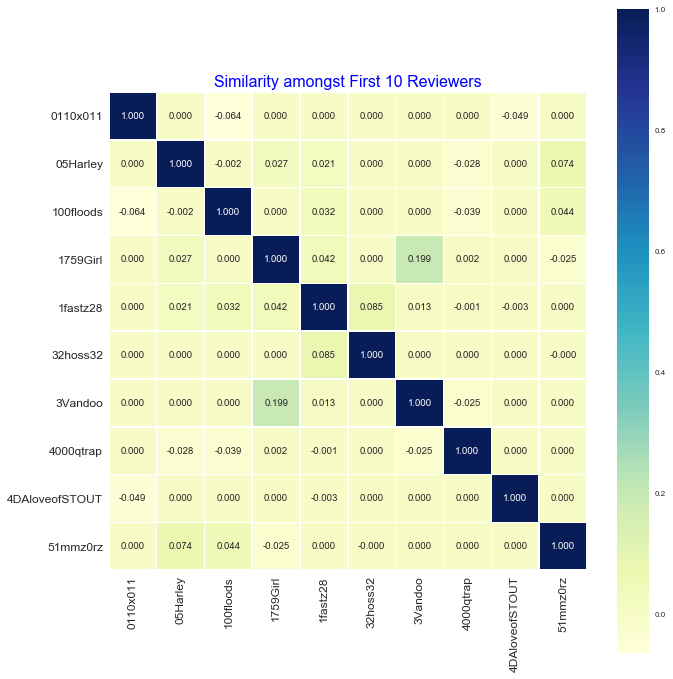

In [403]:
# buildin a heatmap of correlation of first 10 users
plt.figure(figsize=(10,10))

sns.heatmap(Fst_10_reviewers_corr, cmap="YlGnBu", linewidths = 0.5, annot=True,square = True, fmt=".3f")
plt.title('Similarity amongst First 10 Reviewers', size = 16, color = 'b');
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

### Prediction on Training Set

Doing the prediction for the reviewers who are positively related with other reviewers, and not the reviewers which are negatively related as we are interested in the reviewers which are more similar to the current reviewers. So, ignoring the correlation for values less than 0. 

In [404]:
reviewer_correlation[reviewer_correlation<0]=0
reviewer_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.06023922,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.00183073,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.06023922, 0.00183073, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

##### Rating predicted for the reviewer (for beers rated as well as not rated) is the weighted sum of correlation with the beer rating.

In [405]:
reviewer_predicted_ratings = np.dot(reviewer_correlation, beer_features_user.fillna(0))
reviewer_predicted_ratings

array([[0.60740569, 1.72279843, 1.36537555, ..., 0.62420766, 2.78695303,
        0.99231436],
       [1.64187597, 2.19901147, 0.68375015, ..., 0.77148987, 2.04906253,
        0.87085684],
       [0.50868217, 1.82480268, 1.04838097, ..., 0.4432223 , 1.66992617,
        1.01367289],
       ...,
       [5.4615181 , 9.28403854, 6.24694338, ..., 1.13753439, 2.05371077,
        2.43409095],
       [1.94987669, 7.03871264, 4.32649666, ..., 1.48588393, 3.63541061,
        2.413668  ],
       [2.79919408, 5.30058669, 4.10148393, ..., 0.7447872 , 1.28456455,
        1.13771762]])

In [406]:
reviewer_predicted_ratings.shape

(3176, 2064)

##### The training data set has `3176 reviewers` and `2064 beers`. The correlation matrix for user-based similarity will be of the shape `3176 x 3176`. This matrix indicates to what extent the users are related to other users.

##### Multiplying correlation matrix with 'beer_feature' (rating by the reviewer) of shape `3176 x 2064` will give the user-based recommender matrix of shape `3176 x 2064`. 

##### This matrix will contain the user-based rating of all the beers, including the beers not rated by the reviewer, based on the correlation with other reviewers. Thus, we can find the Beer-Recommendation for a reviewer by filtering out the rating given by that reviewer (using 'dummy_train').


*Since we are interested only in the beers not reviewed by the reviewer, we will ignore the beers rated by the reviewer by making it zero. We do this by multiplying it with 'dummy_train' dataframe.* 

In [407]:
reviewer_final_rating = np.multiply(reviewer_predicted_ratings,dummy_train)
reviewer_final_rating.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,...,72138,73131,74123,74272,74323,74390,74548,74579,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.607406,1.722798,1.365376,2.133627,0.369895,0.383252,2.128028,1.836918,2.817660,1.975254,...,3.390042,0.677360,0.326128,0.253216,0.442418,0.547199,0.265393,0.624208,2.786953,0.992314
05Harley,1.641876,2.199011,0.683750,4.119564,1.142683,0.498070,2.202979,2.498159,6.628212,3.453936,...,2.962885,1.561487,1.674791,1.224707,1.361091,0.912850,0.302531,0.771490,2.049063,0.870857
100floods,0.508682,1.824803,1.048381,2.556826,0.508363,0.473822,2.041114,0.524179,4.925649,2.787559,...,2.772751,1.099367,0.921139,0.799246,0.928896,0.406420,0.375718,0.443222,1.669926,1.013673
1759Girl,3.654447,5.765699,5.281095,5.064425,1.357946,1.871067,5.197184,4.365944,13.376856,11.673933,...,8.238620,1.740618,2.625025,1.563181,0.776449,2.044254,0.757676,1.002973,3.981609,2.350628
1fastz28,4.260667,0.000000,4.846008,0.000000,1.676340,2.468645,7.305227,6.270055,17.198941,12.667486,...,6.401570,2.171791,0.000000,2.319006,2.686793,2.116601,1.817929,1.473303,3.677687,3.638288


### Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different movie ID. In the user based similarity, we had taken mean for each user intead of each movie. 

In [408]:
beer_features_item = train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T
beer_features_item.head()

review_profilename,0110x011,05Harley,100floods,1759Girl,1fastz28,32hoss32,3Vandoo,4000qtrap,4DAloveofSTOUT,51mmz0rz,...,zerk,zerofear13,zhanson88,zimm421,zjungleist,zoolzoo,zoso1967,zoso493,zrab11,zymurgy4all
beer_beerid,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalising the movie rating for each movie

In [409]:
mean = np.nanmean(beer_features_item, axis=1)
df_subtracted_item = (beer_features_item.T-mean).T

In [410]:
df_subtracted_item.head()

review_profilename,0110x011,05Harley,100floods,1759Girl,1fastz28,32hoss32,3Vandoo,4000qtrap,4DAloveofSTOUT,51mmz0rz,...,zerk,zerofear13,zhanson88,zimm421,zjungleist,zoolzoo,zoso1967,zoso493,zrab11,zymurgy4all
beer_beerid,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,-0.209559,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.227273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,0.153226,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finding the cosine similarity. Note that since the data is normalised, both the cosine metric and correlation metric will give the same value. 

In [411]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
beer_correlation = 1 - pairwise_distances(df_subtracted_item.fillna(0), metric='cosine')
beer_correlation[np.isnan(beer_correlation)] = 0
print(beer_correlation)

[[ 1.         -0.04400353  0.10450266 ...  0.          0.01444095
   0.        ]
 [-0.04400353  1.          0.09372582 ...  0.0850787   0.0028846
   0.        ]
 [ 0.10450266  0.09372582  1.         ...  0.0035514   0.00416595
  -0.00307617]
 ...
 [ 0.          0.0850787   0.0035514  ...  1.         -0.00953562
   0.02076853]
 [ 0.01444095  0.0028846   0.00416595 ... -0.00953562  1.
  -0.01370386]
 [ 0.          0.         -0.00307617 ...  0.02076853 -0.01370386
   1.        ]]


### First 10 Beers

In [412]:
Fst_10_Beers = df_subtracted_item.index[0:10].values
Fst_10_Beers

array([ 5,  6,  7, 10, 14, 15, 17, 19, 30, 31], dtype=int64)

### Similarity amongst First 10 Beers

In [413]:
Fst_10_beers_corr = pd.DataFrame(beer_correlation[:10,:10])
Fst_10_beers_corr.columns = Fst_10_Beers
Fst_10_beers_corr.index = Fst_10_Beers
Fst_10_beers_corr

,5,6,7,10,14,15,17,19,30,31
5,1.000000,-0.044004,0.104503,-0.029471,-0.010378,-0.008061,-0.027961,-0.046848,-0.006448,0.016354
6,-0.044004,1.000000,0.093726,0.022307,0.017416,0.004390,0.004319,-0.019156,-0.032116,-0.002920
7,0.104503,0.093726,1.000000,-0.030013,-0.078204,-0.007661,0.026361,-0.051896,-0.037479,-0.024096
10,-0.029471,0.022307,-0.030013,1.000000,0.066272,0.059567,-0.003229,0.033588,0.007894,-0.024459
14,-0.010378,0.017416,-0.078204,0.066272,1.000000,0.099416,0.008963,0.034474,0.034500,-0.025723
15,-0.008061,0.004390,-0.007661,0.059567,0.099416,1.000000,-0.010017,0.032583,0.037086,0.025630
17,-0.027961,0.004319,0.026361,-0.003229,0.008963,-0.010017,1.000000,0.015526,-0.017780,0.072509
19,-0.046848,-0.019156,-0.051896,0.033588,0.034474,0.032583,0.015526,1.000000,-0.014294,-0.027806
30,-0.006448,-0.032116,-0.037479,0.007894,0.034500,0.037086,-0.017780,-0.014294,1.000000,0.024280
31,0.016354,-0.002920,-0.024096,-0.024459,-0.025723,0.025630,0.072509,-0.027806,0.024280,1.000000


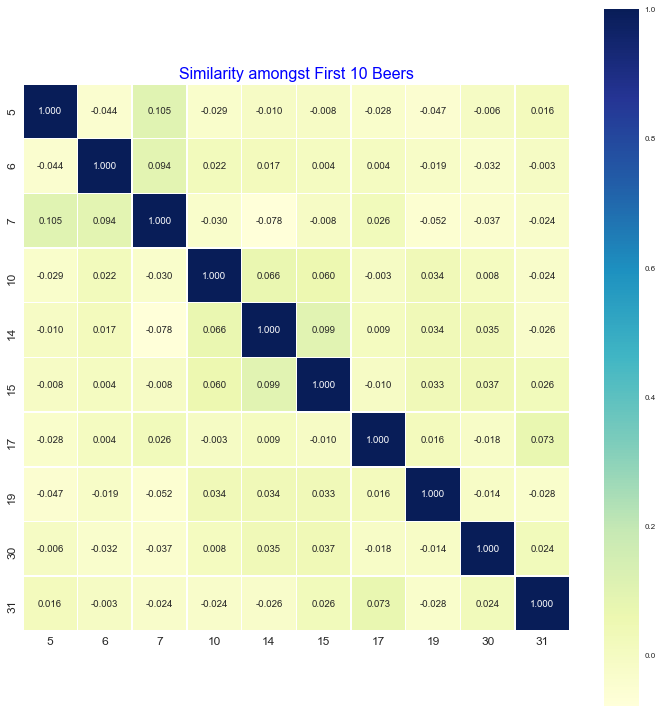

In [414]:
# buildin a heatmap of correlation of first 10 users
plt.figure(figsize=(10,10))

sns.heatmap(Fst_10_beers_corr, cmap="YlGnBu", linewidths = 0.5, annot=True,square = True, fmt=".3f")
plt.title('Similarity amongst First 10 Beers', size = 16, color = 'b');
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

### Prediction on the Training Set

Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [415]:
beer_correlation[beer_correlation<0]=0
beer_correlation

array([[1.        , 0.        , 0.10450266, ..., 0.        , 0.01444095,
        0.        ],
       [0.        , 1.        , 0.09372582, ..., 0.0850787 , 0.0028846 ,
        0.        ],
       [0.10450266, 0.09372582, 1.        , ..., 0.0035514 , 0.00416595,
        0.        ],
       ...,
       [0.        , 0.0850787 , 0.0035514 , ..., 1.        , 0.        ,
        0.02076853],
       [0.01444095, 0.0028846 , 0.00416595, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02076853, 0.        ,
        1.        ]])

In [416]:
beer_predicted_ratings = np.dot((beer_features_item.fillna(0).T),beer_correlation)
beer_predicted_ratings

array([[0.34235531, 0.75140313, 0.3725019 , ..., 0.4798347 , 0.51727737,
        0.77667071],
       [0.71201797, 0.61201673, 0.74136727, ..., 0.29537101, 0.96046555,
        0.70915081],
       [0.4610979 , 0.57293613, 0.84695463, ..., 0.44862372, 1.62539371,
        1.21536412],
       ...,
       [1.05588008, 1.64889637, 1.67259081, ..., 0.39409505, 0.7575991 ,
        1.69761257],
       [1.05237359, 1.68876966, 1.94192558, ..., 1.24434921, 1.03048876,
        1.72885155],
       [0.77920154, 0.98848806, 1.95106329, ..., 0.22335889, 0.2721665 ,
        0.45937481]])

In [417]:
beer_predicted_ratings.shape

(3176, 2064)

In [418]:
dummy_train.shape

(3176, 2064)

### Filtering the rating only for the movies not rated by the user for recommendation

In [419]:
beer_final_rating = np.multiply(beer_predicted_ratings,dummy_train)
beer_final_rating.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,...,72138,73131,74123,74272,74323,74390,74548,74579,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.342355,0.751403,0.372502,0.373032,0.438093,0.606722,1.266867,0.346784,1.825658,0.633090,...,1.191960,0.412804,0.409965,0.477528,0.291183,0.658500,0.153989,0.479835,0.517277,0.776671
05Harley,0.712018,0.612017,0.741367,0.816150,1.197436,1.189673,0.377426,0.574105,1.825379,0.655822,...,0.852472,0.167492,0.283364,0.594851,0.426807,0.882157,1.132680,0.295371,0.960466,0.709151
100floods,0.461098,0.572936,0.846955,0.399168,0.330429,0.904166,0.991984,0.350883,1.398217,0.663469,...,0.914051,0.767967,1.061601,0.782607,0.977393,0.424092,1.789367,0.448624,1.625394,1.215364
1759Girl,1.030794,1.233836,1.835413,1.391103,0.720516,0.934950,1.466819,0.566264,1.926939,1.461998,...,0.786347,1.258554,1.002897,1.065330,0.618888,0.886222,1.026076,0.433305,1.075807,1.523836
1fastz28,2.173427,0.000000,3.898027,0.000000,3.264602,3.261925,3.998928,2.687456,2.711403,4.235729,...,3.086705,3.051129,0.000000,1.828889,1.196344,1.753731,3.142080,1.587389,1.649391,4.243231


## Step 6: Evaluation

Evaluation will be same as prediction. The only difference being, we will evaluate for the beer already rated by the reviewer instead of predicting it for the beer not rated by the reviewer. 

### Using User Similarity

In [420]:
test_beer_features_user = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

mean = np.nanmean(test_beer_features_user, axis=1)
test_df_subtracted = (test_beer_features_user.T-mean).T

# User Similarity Matrix
test_reviewer_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_reviewer_correlation[np.isnan(test_reviewer_correlation)] = 0
print(test_reviewer_correlation)

[[ 1.00000000e+00 -9.94756754e-03  0.00000000e+00 ...  8.12730982e-04
   6.02316422e-02  0.00000000e+00]
 [-9.94756754e-03  1.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 8.12730982e-04  0.00000000e+00  0.00000000e+00 ...  1.00000000e+00
   3.81129997e-03  0.00000000e+00]
 [ 6.02316422e-02  0.00000000e+00  0.00000000e+00 ...  3.81129997e-03
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]


In [421]:
test_reviewer_correlation[test_reviewer_correlation<0]=0
test_reviewer_predicted_ratings = np.dot(test_reviewer_correlation, test_beer_features_user.fillna(0))
test_reviewer_predicted_ratings

array([[0.41939745, 0.2239049 , 0.79532046, ..., 0.54059044, 2.14354489,
        0.21766579],
       [0.36384749, 0.20596454, 0.60289483, ..., 1.26725901, 0.00927267,
        0.75379087],
       [0.07257225, 0.2557648 , 0.36255464, ..., 0.11783901, 0.15126308,
        0.01956389],
       ...,
       [1.39301769, 3.26215724, 1.17950817, ..., 1.32916552, 0.09780408,
        1.45608938],
       [0.77927749, 0.80168546, 0.31702962, ..., 0.18221054, 0.80894388,
        0.48848761],
       [0.71590046, 1.05053414, 0.59297741, ..., 0.        , 1.08198966,
        0.04651303]])

### Doing prediction for the movies rated by the user

In [422]:
test_reviewer_final_rating = np.multiply(test_reviewer_predicted_ratings,dummy_test)

In [423]:
test_reviewer_final_rating.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,...,72138,73131,74123,74272,74323,74390,74548,74579,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100floods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1759Girl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1fastz28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculating the RMSE for only the beers rated by user. For  RMSE, normalising the rating to (1,5) range. 

In [425]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_reviewer_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [426]:
test_ = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [427]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [428]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

1.8020010881328037


### Using Item similarity

In [429]:
test_beer_features_item = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T

mean = np.nanmean(test_beer_features_item, axis=1)
test_df_subtracted = (test_beer_features_item.T-mean).T

test_beer_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_beer_correlation[np.isnan(test_beer_correlation)] = 0
test_beer_correlation[test_beer_correlation<0]=0

In [430]:
test_beer_correlation.shape

(2064, 2064)

In [431]:
test_beer_features_item.shape

(2064, 3174)

In [432]:
test_beer_predicted_ratings = (np.dot(test_beer_correlation, test_beer_features_item.fillna(0))).T
test_beer_final_rating = np.multiply(test_beer_predicted_ratings,dummy_test)
test_beer_final_rating.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,...,72138,73131,74123,74272,74323,74390,74548,74579,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100floods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1759Girl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1fastz28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculating the RMSE for only the beers rated by user. For  RMSE, normalising the rating to (1,5) range. 

In [434]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_beer_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))


test_ = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

MinMaxScaler(copy=True, feature_range=(1, 5))


### Finding RMSE

In [435]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.095085268824015


## Step 7: Top 5 Recommendations for the Users

#### Finding the Top 5 Recommendations for the Users - 'cokes', 'genog' & 'giblet' using Used based Recommendation:

In [438]:
print(test_reviewer_final_rating.loc[['cokes']].sort_values(by ='cokes', axis=1, ascending=False).iloc[:,0:5])
print("---------------------------------------------------------------------------------------")
print(test_reviewer_final_rating.loc[['genog']].sort_values(by ='genog', axis=1, ascending=False).iloc[:,0:5])
print("---------------------------------------------------------------------------------------")
print(test_reviewer_final_rating.loc[['giblet']].sort_values(by ='giblet', axis=1, ascending=False).iloc[:,0:5])

beer_beerid             1708       695        1160       1545       11922
review_profilename                                                       
cokes               26.795677  25.044004  18.809359  18.500927  13.500259
---------------------------------------------------------------------------------------
beer_beerid             17112      34         299       42533      1493 
review_profilename                                                      
genog               26.749033  25.431692  14.148227  13.86623  13.400123
---------------------------------------------------------------------------------------
beer_beerid             645        695       92         17112      276  
review_profilename                                                      
giblet              40.628286  31.243899  31.01686  30.946544  25.702596


#### Finding the Top 5 Recommendations for the Users - 'cokes', 'genog' & 'giblet' using Item based Recommendation:

In [437]:
print(test_beer_final_rating.loc[['cokes']].sort_values(by ='cokes', axis=1, ascending=False).iloc[:,0:5])
print("---------------------------------------------------------------------------------------")
print(test_beer_final_rating.loc[['genog']].sort_values(by ='genog', axis=1, ascending=False).iloc[:,0:5])
print("---------------------------------------------------------------------------------------")
print(test_beer_final_rating.loc[['giblet']].sort_values(by ='giblet', axis=1, ascending=False).iloc[:,0:5])

beer_beerid             16115      17770      2576       2585       58   
review_profilename                                                       
cokes               21.126965  19.924084  18.003963  15.883643  13.701887
---------------------------------------------------------------------------------------
beer_beerid            42533     1493      40057   28577     28350
review_profilename                                                
genog               6.810862  6.807144  6.457599  6.3493  5.953227
---------------------------------------------------------------------------------------
beer_beerid            935       772       1867      695       92  
review_profilename                                                 
giblet              6.11122  6.053825  6.009589  5.924982  5.865257


## <font color = blue>Conclusion:</font>

#### RMSE is used as evaluation metrics for both the models - 

|Collaborative Recommendation|RMSE value|
|-------------------------|----------|
|User based|<font color = red>1.802</font>|
|Item based|2.095|

*`Root-Mean-Square Error (RMSE)` is an absolute measure of fit. RMSE is a measure of how accurately the model makes a prediction. *

##### Lower values of RMSE indicate better fit when 2 models are compared. Therefore in this case, `User based Collaborative Filtering` with a lower value of RMSE is a better predictor of recommendations.